<a href="https://colab.research.google.com/github/firdowsacige/brain_tumor/blob/main/Deeplabv3%2B_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:

# Mount Google Drive (Optional, if saving models)
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
pip install tensorflow

In [3]:
!pip install opencv-python-headless


In [4]:
# Importing dependencies

import warnings
warnings.filterwarnings('ignore')
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
import random
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow.keras import backend as K
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Layer
from tensorflow.keras.callbacks import Callback
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import Input, Conv2D, UpSampling2D, Dropout,Concatenate, BatchNormalization, SeparableConv2D
from tensorflow.keras.layers import Activation, MaxPooling2D, AveragePooling2D, Dense, concatenate, GlobalAveragePooling2D


SEED = 65
IMG_SIZE = 224,224
BATCH_SIZE = 8
AUTO = tf.data.AUTOTUNE

In [5]:
!pip install wget
import wget
import zipfile

  Preparing metadata (setup.py) ... done
  Created wheel for wget: filename=wget-3.2-py3-none-any.whl size=9655 sha256=2ff5b162563746291091b0cd11acd88bbff2121354d3ee6f765b21d5202a7373
  Stored in directory: /root/.cache/pip/wheels/40/b3/0f/a40dbd1c6861731779f62cc4babcb234387e11d697df70ee97
Successfully built wget


In [6]:
url = "http://datasets.simula.no/downloads/kvasir-seg.zip"
zip_path = "kvasir-seg.zip"
wget.download(url, zip_path)

'kvasir-seg.zip'

In [7]:
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall("/content/kvasir_seg")

In [8]:
!pip install torchinfo


In [9]:
import os
import pandas as pd
from sklearn.utils import shuffle

# Your directories
image_dir = "/content/kvasir_seg/Kvasir-SEG/images"
mask_dir = "/content/kvasir_seg/Kvasir-SEG/masks"

# List image and mask files
image_files = sorted(os.listdir(image_dir))
mask_files = sorted(os.listdir(mask_dir))

# Make full paths
images = [os.path.join(image_dir, img) for img in image_files]
masks = [os.path.join(mask_dir, msk) for msk in mask_files]

# Create DataFrame
full_data = pd.DataFrame({'image': images, 'mask': masks})

# Shuffle the data
full_data = shuffle(full_data).reset_index(drop=True)

# Show a few rows
display(full_data.head())


,image,mask
0,/content/kvasir_seg/Kvasir-SEG/images/cju7d8m3...,/content/kvasir_seg/Kvasir-SEG/masks/cju7d8m3b...
1,/content/kvasir_seg/Kvasir-SEG/images/cju85dx6...,/content/kvasir_seg/Kvasir-SEG/masks/cju85dx63...
2,/content/kvasir_seg/Kvasir-SEG/images/cju6z261...,/content/kvasir_seg/Kvasir-SEG/masks/cju6z2616...
3,/content/kvasir_seg/Kvasir-SEG/images/cju88q6h...,/content/kvasir_seg/Kvasir-SEG/masks/cju88q6h6...
4,/content/kvasir_seg/Kvasir-SEG/images/cju2pmht...,/content/kvasir_seg/Kvasir-SEG/masks/cju2pmhtr...


In [10]:

SEED = 65
X_train, X_test, y_train, y_test = train_test_split(
    full_data['image'], full_data['mask'], test_size=0.2, random_state=SEED
)


print("X_train shape -> ", X_train.shape)
print("X_test shape -> ", X_test.shape)

X_train shape ->  (800,)
X_test shape ->  (200,)


In [11]:
# Reading and resizing images and masks

def img_preprocessing(image, mask):
    img = tf.io.read_file(image)
    img = tf.io.decode_jpeg(img, channels = 3)
    img = tf.image.resize(img, size = (IMG_SIZE))
    img = tf.cast(img, tf.float32) / 255.0

    mask = tf.io.read_file(mask)
    mask = tf.io.decode_jpeg(mask, channels = 1)
    mask = tf.image.resize(mask, size = (IMG_SIZE))
    mask = tf.cast(mask, tf.float32) / 255.0

    return img, mask

In [12]:
# Creating dataset loaders and tf.datasets

train_loader = tf.data.Dataset.from_tensor_slices((X_train, y_train))
train_dataset = (train_loader
                 .map(img_preprocessing, num_parallel_calls = AUTO)
                 .batch(BATCH_SIZE)
                 .shuffle(X_train.shape[0])
                 .prefetch(AUTO))





test_loader = tf.data.Dataset.from_tensor_slices((X_test, y_test))
test_dataset = (test_loader
                .map(img_preprocessing, num_parallel_calls = AUTO)
                .batch(BATCH_SIZE)
                .prefetch(AUTO))

In [13]:
# Convolutional block class

class ConvBlock(Layer):
    def __init__(self, filters, kernel_size, dilation_rate, batch = False, padding = 'same', activation = 'relu', use_bias = False, **kwargs):
        super(ConvBlock, self).__init__(**kwargs)
        self.filters = filters
        self.kernel_size = kernel_size
        self.dilation_rate = dilation_rate
        self.batch = batch
        self.padding = padding
        self.activation = activation
        self.use_bias = use_bias

        self.conv = Conv2D(filters, kernel_size = kernel_size, dilation_rate = dilation_rate, padding = padding, use_bias = use_bias, kernel_initializer = 'he_normal')
        self.norm = BatchNormalization()
        self.act = Activation(activation)

    def call(self, inputs):
        X = self.conv(inputs)
        if self.batch:
            X = self.norm(X)
            X = self.act(X)
            return X
        else:
            X = self.act(X)
            return X


    def get_config(self):
        base_config = super().get_config()
        return {
            **base_config,
            "filters" : self.filters,
            "kernel_size" : self.kernel_size,
            "dilation_rate" : self.dilation_rate,
            "activation" : self.act,
            "batch" : self.batch }

In [14]:
# DilatedSpatialPyramidPooling class for DeepLabv3+ model

class DilatedSpatialPyramidPooling(Layer):
    def __init__(self, input_layer, kernel_1, kernel_2, kernel_3, kernel_4, dil1, dil2, dil3, dil4, **kwargs):
        super(DilatedSpatialPyramidPooling, self).__init__(**kwargs)
        self.input_layer = input_layer
        self.kernel_1 = kernel_1
        self.kernel_2 = kernel_2
        self.kernel_3 = kernel_3
        self.kernel_4 = kernel_4
        self.dil1 = dil1
        self.dil2 = dil2
        self.dil3 = dil3
        self.dil4 = dil4

        self.pool = AveragePooling2D(pool_size = (input_layer.shape[-3], input_layer.shape[-2]))
        self.convblock = ConvBlock(filters = 256, kernel_size=1, dilation_rate=1, batch = True, use_bias=True)
        self.outpool = UpSampling2D(size=(32,32), interpolation="bilinear")
        self.convout1 = ConvBlock(filters = 256, kernel_size = kernel_1, dilation_rate = dil1, batch = True)
        self.convout2 = ConvBlock(filters = 256, kernel_size = kernel_2, dilation_rate = dil2, batch = True)
        self.convout3 = ConvBlock(filters = 256, kernel_size = kernel_3, dilation_rate = dil3, batch = True)
        self.convout4 = ConvBlock(filters = 256, kernel_size = kernel_4, dilation_rate = dil4, batch = True)
        self.outconv = ConvBlock(filters = 256, kernel_size = 1, dilation_rate=1, batch = True)


    def call(self, inputs):
        X = self.pool(inputs)
        X = self.convblock(X)
        X_p = self.outpool(X)
        X_1 = self.convout1(inputs)
        X_2 = self.convout2(inputs)
        X_3 = self.convout3(inputs)
        X_4 = self.convout4(inputs)

        C = concatenate([X_p, X_1, X_2, X_3, X_4], axis = -1)
        X = self.outconv(C)
        return X


    def get_config(self):
        base_config = super().get_config()
        return {
            **base_config,
            "input_layer": self.input_layer,
            "kernel_1" : self.kernel_1,
            "kernel_2" : self.kernel_2,
            "kernel_3" : self.kernel_3,
            "kernel_4" : self.kernel_4,
            "dil1" : self.dil1,
            "dil2" : self.dil2,
            "dil3" : self.dil3,
            "dil4" : self.dil4}

In [15]:
import tensorflow as tf
from tensorflow.keras.layers import Layer, AveragePooling2D, Conv2D, UpSampling2D, Concatenate

class DilatedSpatialPyramidPooling(Layer):
    def __init__(self, kernel_1, kernel_2, kernel_3, kernel_4, dil1, dil2, dil3, dil4):
        super().__init__()
        self.avg_pool = AveragePooling2D(pool_size=(2, 2))  # use smaller pool if needed
        self.upsample = UpSampling2D(size=(2, 2), interpolation='bilinear')

        self.convout1 = Conv2D(256, kernel_1, dilation_rate=dil1, padding='same')
        self.convout2 = Conv2D(256, kernel_2, dilation_rate=dil2, padding='same')
        self.convout3 = Conv2D(256, kernel_3, dilation_rate=dil3, padding='same')
        self.convout4 = Conv2D(256, kernel_4, dilation_rate=dil4, padding='same')
        self.outconv = Conv2D(256, 1, padding='same')

    def call(self, inputs):
        input_shape = tf.shape(inputs)[1:3]  # get spatial size dynamically (e.g., 14x14)

        X_p = self.avg_pool(inputs)
        X_p = self.upsample(X_p)  # bring to input spatial size (14x14)
        X_1 = self.convout1(inputs)
        X_2 = self.convout2(inputs)
        X_3 = self.convout3(inputs)
        X_4 = self.convout4(inputs)

        # Make sure all shapes are the same before concatenation
        X_p = tf.image.resize(X_p, input_shape, method='bilinear')

        C = Concatenate(axis=-1)([X_p, X_1, X_2, X_3, X_4])
        X = self.outconv(C)
        return X



    def get_config(self):
        base_config = super().get_config()
        return {
            **base_config,
            "input_layer": self.input_layer,
            "kernel_1" : self.kernel_1,
            "kernel_2" : self.kernel_2,
            "kernel_3" : self.kernel_3,
            "kernel_4" : self.kernel_4,
            "dil1" : self.dil1,
            "dil2" : self.dil2,
            "dil3" : self.dil3,
            "dil4" : self.dil4}


In [16]:
# Creating Dice and Jaccard metrics

def dice_coef(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2 * intersection+1) / (K.sum(y_true_f) + K.sum(y_pred_f) + 1)

def dice_coef_loss(y_true, y_pred):
    return 1-dice_coef(y_true, y_pred)

def jaccard(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    jaccard = intersection  / (K.sum(y_true_f) + K.sum(y_pred_f) - intersection + 1e-6 )
    return jaccard

In [17]:
# Custom callback for predicting one sample from test dataset during training each epochs

class PredictDuringTraining(Callback):
    def on_epoch_end(self, epochs, logs = None ):

        if (epochs + 1) % 1 == 0:
            samples = list(test_dataset.take(-1))

            idxs = np.random.permutation(X_test.shape[0])[0]
            batch_idx = idxs // BATCH_SIZE
            image_idx = idxs-batch_idx * BATCH_SIZE
            idx = idxs

            image = samples[batch_idx][0][image_idx]
            mask = samples[batch_idx][1][image_idx]

            pred_mask = self.model.predict(image[np.newaxis,...], verbose = 0)
            pred_ = np.squeeze(pred_mask)
            threshold  = 0.3
            bitmap_pred = (pred_ > threshold).astype(np.uint8)

            fig, axs = plt.subplots(1,3, figsize = (5,2) ,dpi = 120)
            fig.suptitle( 'epoch no :' + str(epochs + 1)  + ' ,images no :' + str(idx) + '\n (github.com/john-fante, kaggle.com/banddaniel)', color='red', fontsize = 8 )

            axs[0].imshow(image , cmap = 'gray')
            axs[0].axis('off')
            axs[0].set_title('original image', fontsize = 6)

            axs[1].imshow(mask, cmap = 'gray')
            axs[1].axis('off')
            axs[1].set_title('original mask', fontsize = 6)

            axs[2].imshow( bitmap_pred, cmap = 'gray')
            axs[2].axis('off')
            axs[2].set_title('predict mask', fontsize = 6)

            plt.tight_layout()
            plt.show()
        else:
            pass


In [18]:
inp = Input(shape = (*IMG_SIZE ,3))
pretrained = ResNet50(weights="imagenet", include_top=False, input_tensor=inp)
X = pretrained.get_layer("conv4_block6_2_relu").output
dsp_block = DilatedSpatialPyramidPooling(kernel_1=1, kernel_2=3, kernel_3=3, kernel_4=3,
                                         dil1=1, dil2=6, dil3=12, dil4=18)
X = dsp_block(X)


X_1 = UpSampling2D(size = (IMG_SIZE[0] // 4 // X.shape[1], IMG_SIZE[0] // 4 // X.shape[2]), interpolation="bilinear")(X)

X_2 = pretrained.get_layer("conv2_block3_2_relu").output
X_2 = ConvBlock(filters=48, kernel_size=1, dilation_rate =1)(X_2)

X = Concatenate(axis=-1)([X_1, X_2])
X = ConvBlock(filters = 256, kernel_size = 3, dilation_rate = 1)(X)
X = ConvBlock(filters = 256, kernel_size = 3, dilation_rate = 1)(X)
X = UpSampling2D(size = (IMG_SIZE[0] // X.shape[1], IMG_SIZE[0] // X.shape[2]), interpolation="bilinear")(X)

out = Conv2D(1, 1 ,activation ='sigmoid', padding = 'same')(X)

model = Model(inputs = inp, outputs = out)
model.summary()
model.compile(optimizer = tf.keras.optimizers.Adam(), loss = 'binary_crossentropy' , metrics = [dice_coef_loss, dice_coef, jaccard])
my_callbacks = [PredictDuringTraining()]


94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 230, 230,  │          0 │ input_layer[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 112, 112,  │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 112, 112,  │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 112, 112,  │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 114, 114,  │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 56, 56,    │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 56, 56,    │      4,160 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 56, 56,    │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 56, 56,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 56, 56,    │     36,928 │ conv2_block1_1_r… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 56, 56,    │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 56, 56,    │          0 │ conv2_block1_2_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 56, 56,    │     16,640 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 56, 56,    │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_0_c… │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_3_c

 Total params: 11,779,457 (44.94 MB)

 Trainable params: 11,750,913 (44.83 MB)

 Non-trainable params: 28,544 (111.50 KB)

Epoch 1/40
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 191ms/step - dice_coef: 0.3534 - dice_coef_loss: 0.6466 - jaccard: 0.2263 - loss: 0.4656

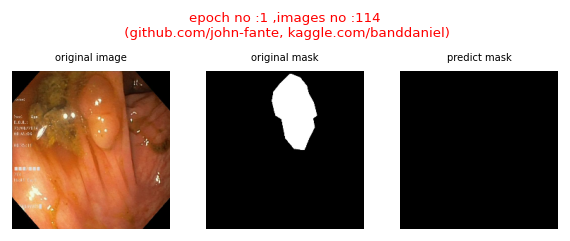

100/100 ━━━━━━━━━━━━━━━━━━━━ 83s 242ms/step - dice_coef: 0.3545 - dice_coef_loss: 0.6455 - jaccard: 0.2272 - loss: 0.4641
Epoch 2/40
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 198ms/step - dice_coef: 0.6445 - dice_coef_loss: 0.3555 - jaccard: 0.4786 - loss: 0.1901

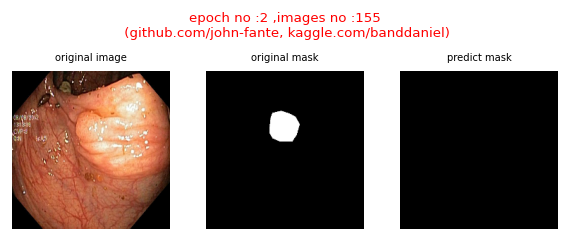

100/100 ━━━━━━━━━━━━━━━━━━━━ 21s 201ms/step - dice_coef: 0.6444 - dice_coef_loss: 0.3556 - jaccard: 0.4784 - loss: 0.1902
Epoch 3/40
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 202ms/step - dice_coef: 0.6986 - dice_coef_loss: 0.3014 - jaccard: 0.5387 - loss: 0.1628

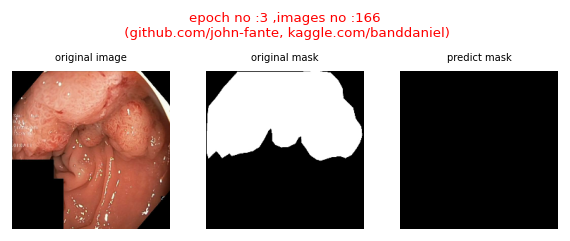

100/100 ━━━━━━━━━━━━━━━━━━━━ 21s 206ms/step - dice_coef: 0.6985 - dice_coef_loss: 0.3015 - jaccard: 0.5386 - loss: 0.1628
Epoch 4/40
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 198ms/step - dice_coef: 0.7687 - dice_coef_loss: 0.2313 - jaccard: 0.6271 - loss: 0.1218

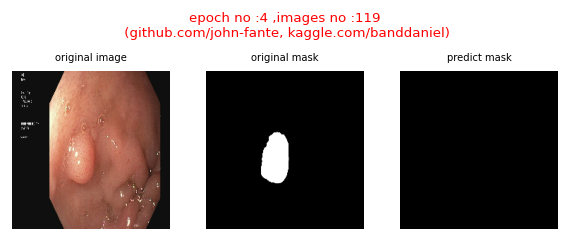

100/100 ━━━━━━━━━━━━━━━━━━━━ 20s 201ms/step - dice_coef: 0.7687 - dice_coef_loss: 0.2313 - jaccard: 0.6271 - loss: 0.1218
Epoch 5/40
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 196ms/step - dice_coef: 0.7922 - dice_coef_loss: 0.2078 - jaccard: 0.6583 - loss: 0.1067

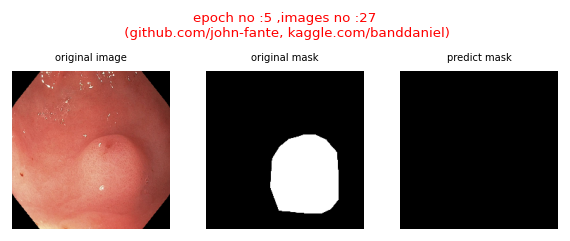

100/100 ━━━━━━━━━━━━━━━━━━━━ 20s 199ms/step - dice_coef: 0.7923 - dice_coef_loss: 0.2077 - jaccard: 0.6585 - loss: 0.1067
Epoch 6/40
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 198ms/step - dice_coef: 0.8358 - dice_coef_loss: 0.1642 - jaccard: 0.7208 - loss: 0.0839

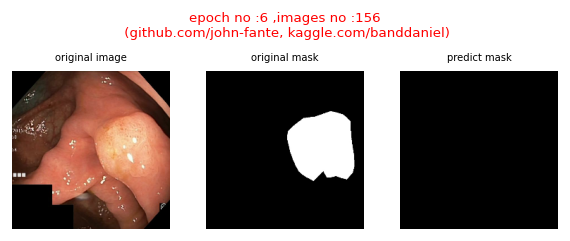

100/100 ━━━━━━━━━━━━━━━━━━━━ 20s 201ms/step - dice_coef: 0.8358 - dice_coef_loss: 0.1642 - jaccard: 0.7209 - loss: 0.0839
Epoch 7/40
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 198ms/step - dice_coef: 0.8555 - dice_coef_loss: 0.1445 - jaccard: 0.7505 - loss: 0.0726

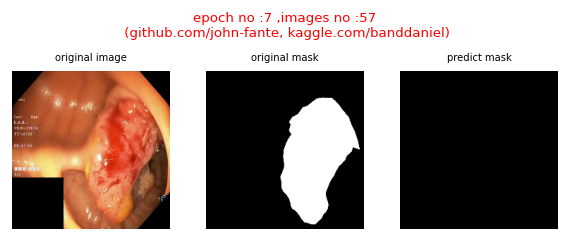

100/100 ━━━━━━━━━━━━━━━━━━━━ 41s 202ms/step - dice_coef: 0.8555 - dice_coef_loss: 0.1445 - jaccard: 0.7505 - loss: 0.0726
Epoch 8/40
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 203ms/step - dice_coef: 0.8835 - dice_coef_loss: 0.1165 - jaccard: 0.7926 - loss: 0.0625

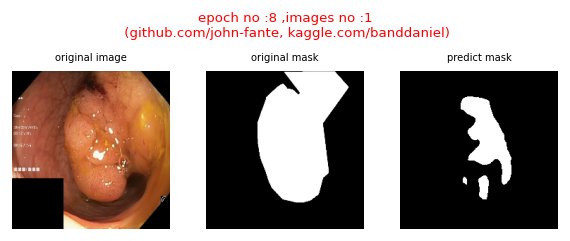

100/100 ━━━━━━━━━━━━━━━━━━━━ 21s 206ms/step - dice_coef: 0.8834 - dice_coef_loss: 0.1166 - jaccard: 0.7924 - loss: 0.0626
Epoch 9/40
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 198ms/step - dice_coef: 0.8817 - dice_coef_loss: 0.1183 - jaccard: 0.7906 - loss: 0.0632

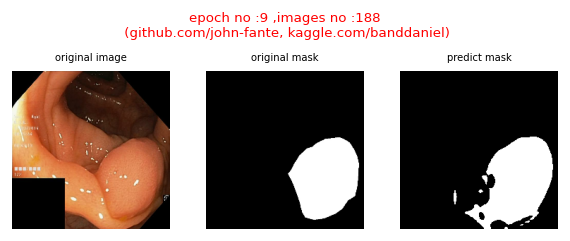

100/100 ━━━━━━━━━━━━━━━━━━━━ 21s 202ms/step - dice_coef: 0.8818 - dice_coef_loss: 0.1182 - jaccard: 0.7907 - loss: 0.0631
Epoch 10/40
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 196ms/step - dice_coef: 0.9225 - dice_coef_loss: 0.0775 - jaccard: 0.8567 - loss: 0.0408

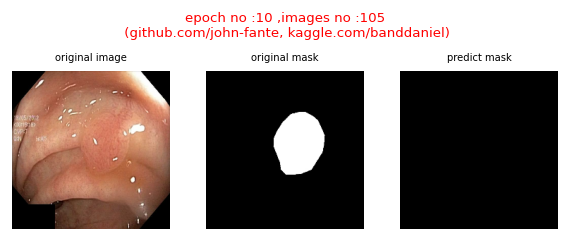

100/100 ━━━━━━━━━━━━━━━━━━━━ 20s 200ms/step - dice_coef: 0.9225 - dice_coef_loss: 0.0775 - jaccard: 0.8566 - loss: 0.0408
Epoch 11/40
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 197ms/step - dice_coef: 0.9257 - dice_coef_loss: 0.0743 - jaccard: 0.8624 - loss: 0.0377

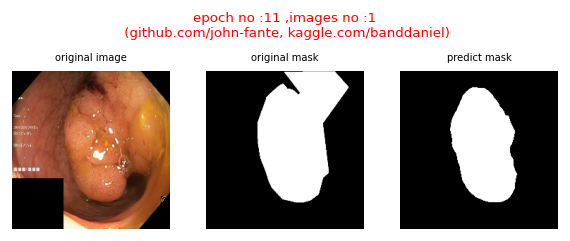

100/100 ━━━━━━━━━━━━━━━━━━━━ 20s 200ms/step - dice_coef: 0.9258 - dice_coef_loss: 0.0742 - jaccard: 0.8625 - loss: 0.0377
Epoch 12/40
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 198ms/step - dice_coef: 0.9432 - dice_coef_loss: 0.0568 - jaccard: 0.8929 - loss: 0.0298

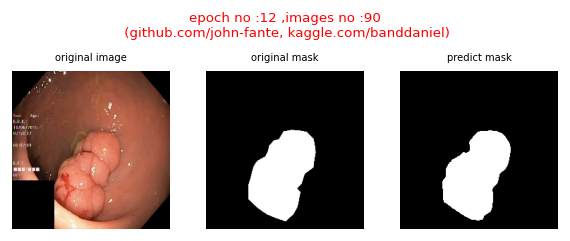

100/100 ━━━━━━━━━━━━━━━━━━━━ 21s 201ms/step - dice_coef: 0.9431 - dice_coef_loss: 0.0569 - jaccard: 0.8928 - loss: 0.0299
Epoch 13/40
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 199ms/step - dice_coef: 0.9376 - dice_coef_loss: 0.0624 - jaccard: 0.8828 - loss: 0.0302

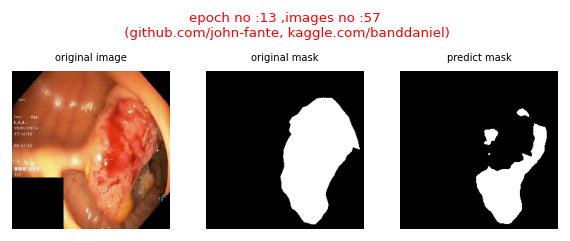

100/100 ━━━━━━━━━━━━━━━━━━━━ 21s 202ms/step - dice_coef: 0.9376 - dice_coef_loss: 0.0624 - jaccard: 0.8828 - loss: 0.0303
Epoch 14/40
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 199ms/step - dice_coef: 0.9386 - dice_coef_loss: 0.0614 - jaccard: 0.8847 - loss: 0.0294

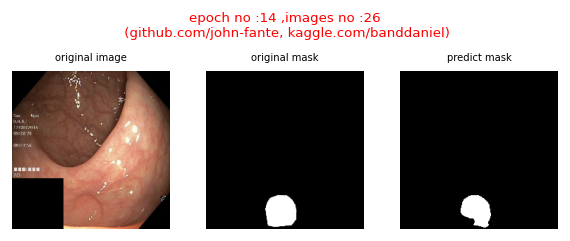

100/100 ━━━━━━━━━━━━━━━━━━━━ 21s 202ms/step - dice_coef: 0.9386 - dice_coef_loss: 0.0614 - jaccard: 0.8847 - loss: 0.0295
Epoch 15/40
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 198ms/step - dice_coef: 0.9324 - dice_coef_loss: 0.0676 - jaccard: 0.8740 - loss: 0.0353

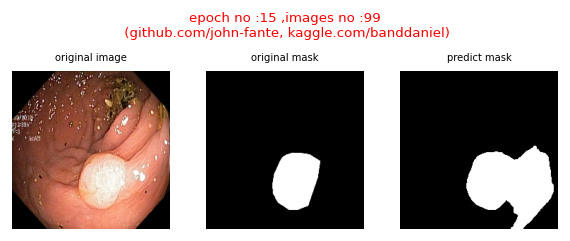

100/100 ━━━━━━━━━━━━━━━━━━━━ 21s 202ms/step - dice_coef: 0.9324 - dice_coef_loss: 0.0676 - jaccard: 0.8740 - loss: 0.0353
Epoch 16/40
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 198ms/step - dice_coef: 0.9275 - dice_coef_loss: 0.0725 - jaccard: 0.8655 - loss: 0.0377

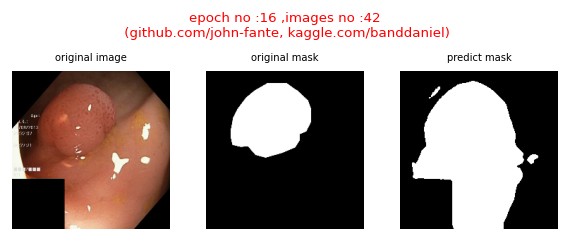

100/100 ━━━━━━━━━━━━━━━━━━━━ 21s 202ms/step - dice_coef: 0.9274 - dice_coef_loss: 0.0726 - jaccard: 0.8653 - loss: 0.0378
Epoch 17/40
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 199ms/step - dice_coef: 0.8349 - dice_coef_loss: 0.1651 - jaccard: 0.7202 - loss: 0.0869

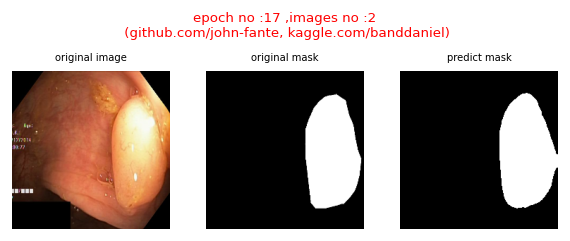

100/100 ━━━━━━━━━━━━━━━━━━━━ 21s 202ms/step - dice_coef: 0.8351 - dice_coef_loss: 0.1649 - jaccard: 0.7205 - loss: 0.0868
Epoch 18/40
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 198ms/step - dice_coef: 0.8995 - dice_coef_loss: 0.1005 - jaccard: 0.8190 - loss: 0.0530

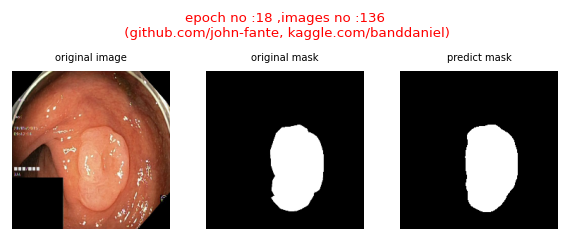

100/100 ━━━━━━━━━━━━━━━━━━━━ 21s 201ms/step - dice_coef: 0.8996 - dice_coef_loss: 0.1004 - jaccard: 0.8192 - loss: 0.0530
Epoch 19/40
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 197ms/step - dice_coef: 0.9338 - dice_coef_loss: 0.0662 - jaccard: 0.8761 - loss: 0.0339

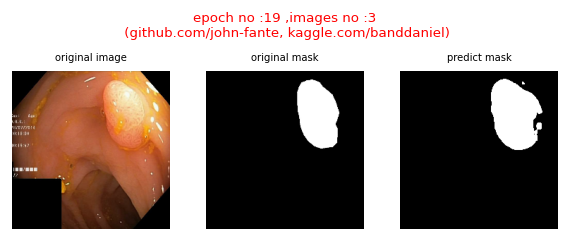

100/100 ━━━━━━━━━━━━━━━━━━━━ 20s 200ms/step - dice_coef: 0.9338 - dice_coef_loss: 0.0662 - jaccard: 0.8762 - loss: 0.0339
Epoch 20/40
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 198ms/step - dice_coef: 0.9426 - dice_coef_loss: 0.0574 - jaccard: 0.8917 - loss: 0.0287

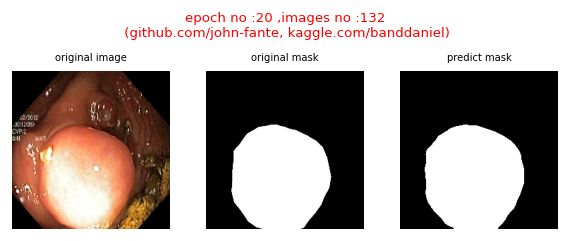

100/100 ━━━━━━━━━━━━━━━━━━━━ 21s 201ms/step - dice_coef: 0.9426 - dice_coef_loss: 0.0574 - jaccard: 0.8917 - loss: 0.0287
Epoch 21/40
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 199ms/step - dice_coef: 0.9528 - dice_coef_loss: 0.0472 - jaccard: 0.9101 - loss: 0.0251

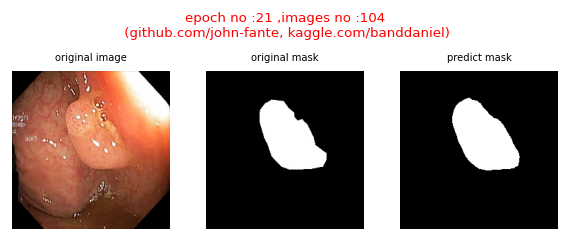

100/100 ━━━━━━━━━━━━━━━━━━━━ 21s 203ms/step - dice_coef: 0.9528 - dice_coef_loss: 0.0472 - jaccard: 0.9101 - loss: 0.0251
Epoch 22/40
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 198ms/step - dice_coef: 0.9600 - dice_coef_loss: 0.0400 - jaccard: 0.9232 - loss: 0.0208

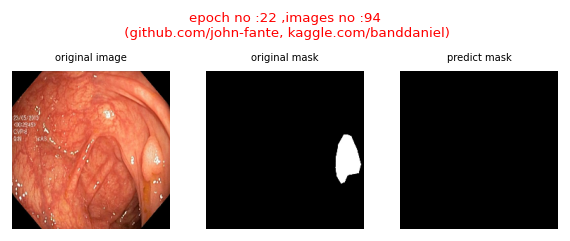

100/100 ━━━━━━━━━━━━━━━━━━━━ 21s 202ms/step - dice_coef: 0.9600 - dice_coef_loss: 0.0400 - jaccard: 0.9232 - loss: 0.0208
Epoch 23/40
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 197ms/step - dice_coef: 0.9647 - dice_coef_loss: 0.0353 - jaccard: 0.9318 - loss: 0.0173

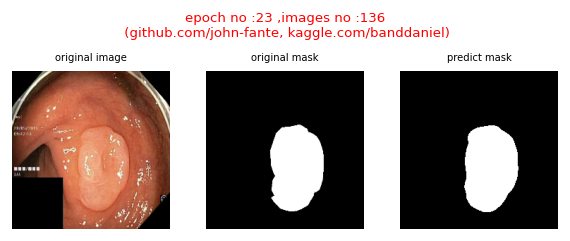

100/100 ━━━━━━━━━━━━━━━━━━━━ 21s 201ms/step - dice_coef: 0.9647 - dice_coef_loss: 0.0353 - jaccard: 0.9318 - loss: 0.0173
Epoch 24/40
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 198ms/step - dice_coef: 0.9690 - dice_coef_loss: 0.0310 - jaccard: 0.9400 - loss: 0.0161

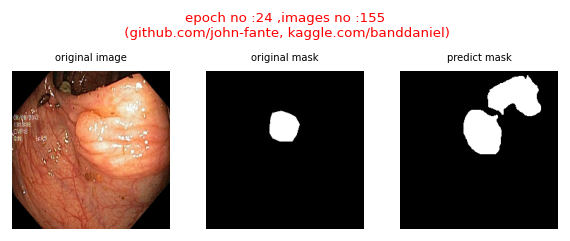

100/100 ━━━━━━━━━━━━━━━━━━━━ 21s 201ms/step - dice_coef: 0.9690 - dice_coef_loss: 0.0310 - jaccard: 0.9399 - loss: 0.0161
Epoch 25/40
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 199ms/step - dice_coef: 0.9701 - dice_coef_loss: 0.0299 - jaccard: 0.9420 - loss: 0.0148

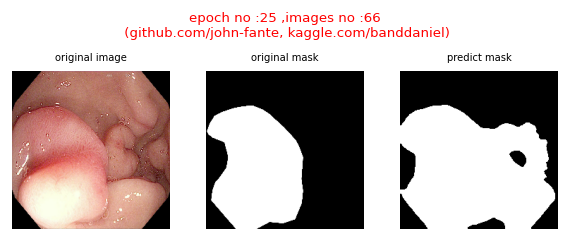

100/100 ━━━━━━━━━━━━━━━━━━━━ 21s 202ms/step - dice_coef: 0.9701 - dice_coef_loss: 0.0299 - jaccard: 0.9420 - loss: 0.0148
Epoch 26/40
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 199ms/step - dice_coef: 0.9714 - dice_coef_loss: 0.0286 - jaccard: 0.9445 - loss: 0.0136

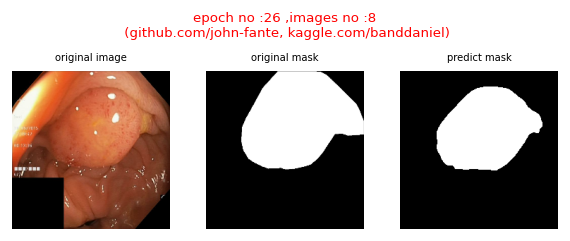

100/100 ━━━━━━━━━━━━━━━━━━━━ 21s 202ms/step - dice_coef: 0.9714 - dice_coef_loss: 0.0286 - jaccard: 0.9444 - loss: 0.0136
Epoch 27/40
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 197ms/step - dice_coef: 0.9735 - dice_coef_loss: 0.0265 - jaccard: 0.9483 - loss: 0.0132

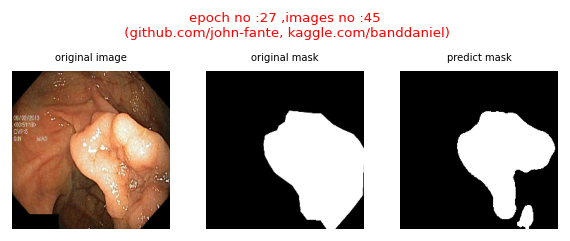

100/100 ━━━━━━━━━━━━━━━━━━━━ 21s 201ms/step - dice_coef: 0.9734 - dice_coef_loss: 0.0266 - jaccard: 0.9483 - loss: 0.0132
Epoch 28/40
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 199ms/step - dice_coef: 0.9731 - dice_coef_loss: 0.0269 - jaccard: 0.9477 - loss: 0.0130

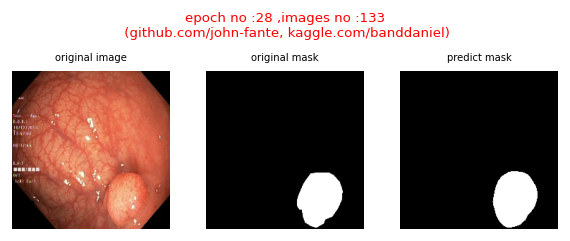

100/100 ━━━━━━━━━━━━━━━━━━━━ 21s 202ms/step - dice_coef: 0.9731 - dice_coef_loss: 0.0269 - jaccard: 0.9477 - loss: 0.0130
Epoch 29/40
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 199ms/step - dice_coef: 0.9727 - dice_coef_loss: 0.0273 - jaccard: 0.9469 - loss: 0.0134

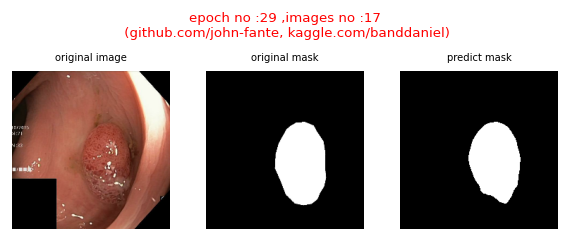

100/100 ━━━━━━━━━━━━━━━━━━━━ 21s 208ms/step - dice_coef: 0.9727 - dice_coef_loss: 0.0273 - jaccard: 0.9469 - loss: 0.0134
Epoch 30/40
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 199ms/step - dice_coef: 0.9737 - dice_coef_loss: 0.0263 - jaccard: 0.9488 - loss: 0.0127

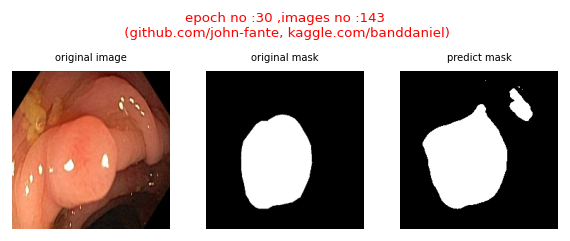

100/100 ━━━━━━━━━━━━━━━━━━━━ 21s 202ms/step - dice_coef: 0.9737 - dice_coef_loss: 0.0263 - jaccard: 0.9489 - loss: 0.0127
Epoch 31/40
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 198ms/step - dice_coef: 0.9763 - dice_coef_loss: 0.0237 - jaccard: 0.9538 - loss: 0.0124

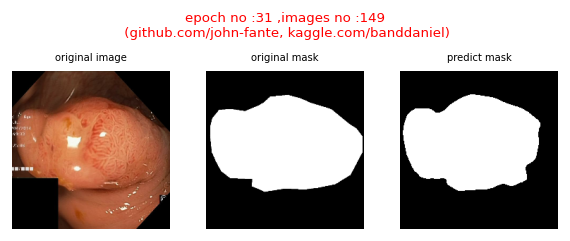

100/100 ━━━━━━━━━━━━━━━━━━━━ 21s 202ms/step - dice_coef: 0.9763 - dice_coef_loss: 0.0237 - jaccard: 0.9538 - loss: 0.0124
Epoch 32/40
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 199ms/step - dice_coef: 0.9770 - dice_coef_loss: 0.0230 - jaccard: 0.9550 - loss: 0.0112

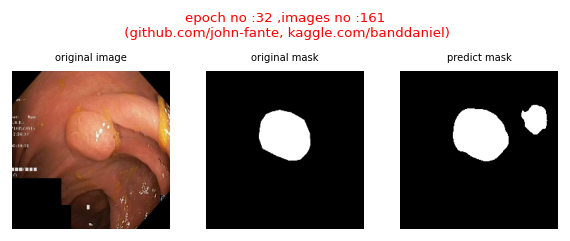

100/100 ━━━━━━━━━━━━━━━━━━━━ 21s 202ms/step - dice_coef: 0.9770 - dice_coef_loss: 0.0230 - jaccard: 0.9550 - loss: 0.0112
Epoch 33/40
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 199ms/step - dice_coef: 0.9774 - dice_coef_loss: 0.0226 - jaccard: 0.9558 - loss: 0.0115

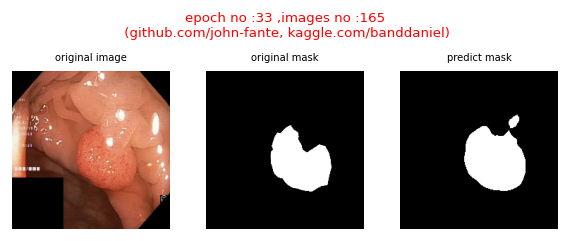

100/100 ━━━━━━━━━━━━━━━━━━━━ 21s 203ms/step - dice_coef: 0.9774 - dice_coef_loss: 0.0226 - jaccard: 0.9558 - loss: 0.0115
Epoch 34/40
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 198ms/step - dice_coef: 0.9773 - dice_coef_loss: 0.0227 - jaccard: 0.9556 - loss: 0.0113

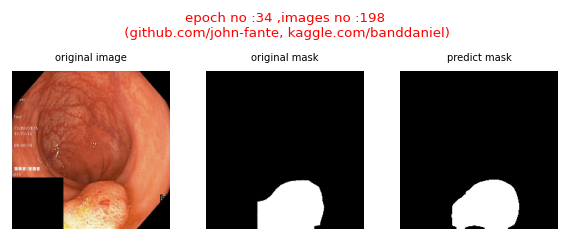

100/100 ━━━━━━━━━━━━━━━━━━━━ 21s 201ms/step - dice_coef: 0.9773 - dice_coef_loss: 0.0227 - jaccard: 0.9556 - loss: 0.0113
Epoch 35/40
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 198ms/step - dice_coef: 0.9777 - dice_coef_loss: 0.0223 - jaccard: 0.9564 - loss: 0.0109

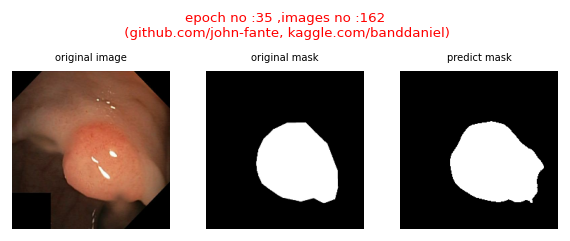

100/100 ━━━━━━━━━━━━━━━━━━━━ 21s 201ms/step - dice_coef: 0.9777 - dice_coef_loss: 0.0223 - jaccard: 0.9564 - loss: 0.0109
Epoch 36/40
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 198ms/step - dice_coef: 0.9792 - dice_coef_loss: 0.0208 - jaccard: 0.9593 - loss: 0.0103

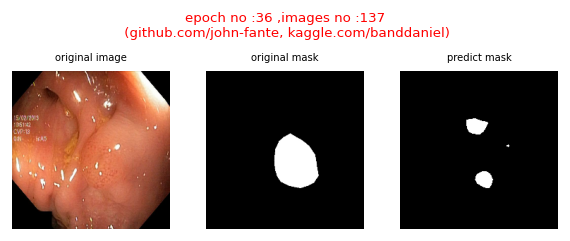

100/100 ━━━━━━━━━━━━━━━━━━━━ 21s 201ms/step - dice_coef: 0.9792 - dice_coef_loss: 0.0208 - jaccard: 0.9593 - loss: 0.0103
Epoch 37/40
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 198ms/step - dice_coef: 0.9786 - dice_coef_loss: 0.0214 - jaccard: 0.9582 - loss: 0.0105

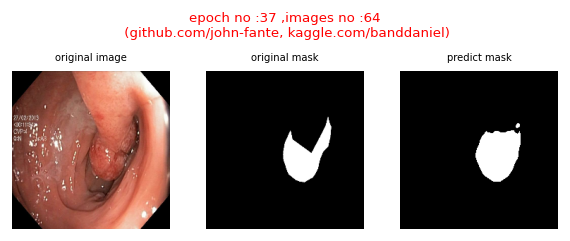

100/100 ━━━━━━━━━━━━━━━━━━━━ 21s 202ms/step - dice_coef: 0.9786 - dice_coef_loss: 0.0214 - jaccard: 0.9582 - loss: 0.0105
Epoch 38/40
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 198ms/step - dice_coef: 0.9790 - dice_coef_loss: 0.0210 - jaccard: 0.9589 - loss: 0.0108

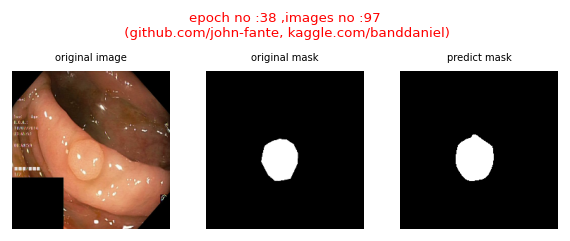

100/100 ━━━━━━━━━━━━━━━━━━━━ 21s 201ms/step - dice_coef: 0.9790 - dice_coef_loss: 0.0210 - jaccard: 0.9589 - loss: 0.0108
Epoch 39/40
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 198ms/step - dice_coef: 0.9795 - dice_coef_loss: 0.0205 - jaccard: 0.9598 - loss: 0.0099

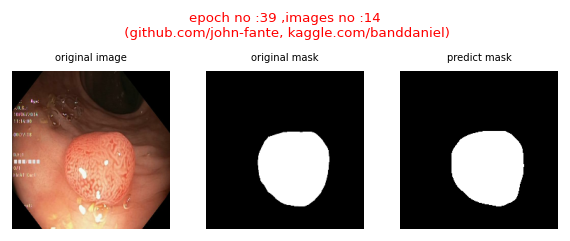

100/100 ━━━━━━━━━━━━━━━━━━━━ 21s 202ms/step - dice_coef: 0.9795 - dice_coef_loss: 0.0205 - jaccard: 0.9598 - loss: 0.0099
Epoch 40/40
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 199ms/step - dice_coef: 0.9807 - dice_coef_loss: 0.0193 - jaccard: 0.9621 - loss: 0.0099

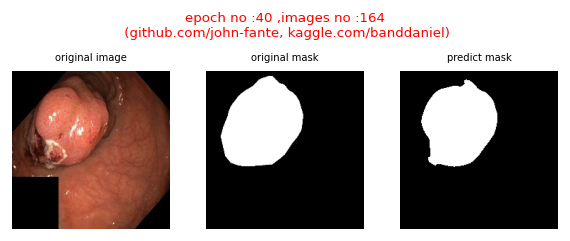

100/100 ━━━━━━━━━━━━━━━━━━━━ 21s 202ms/step - dice_coef: 0.9807 - dice_coef_loss: 0.0193 - jaccard: 0.9621 - loss: 0.0099


In [19]:
hist = model.fit(train_dataset, batch_size = BATCH_SIZE, epochs = 40,  callbacks = my_callbacks)


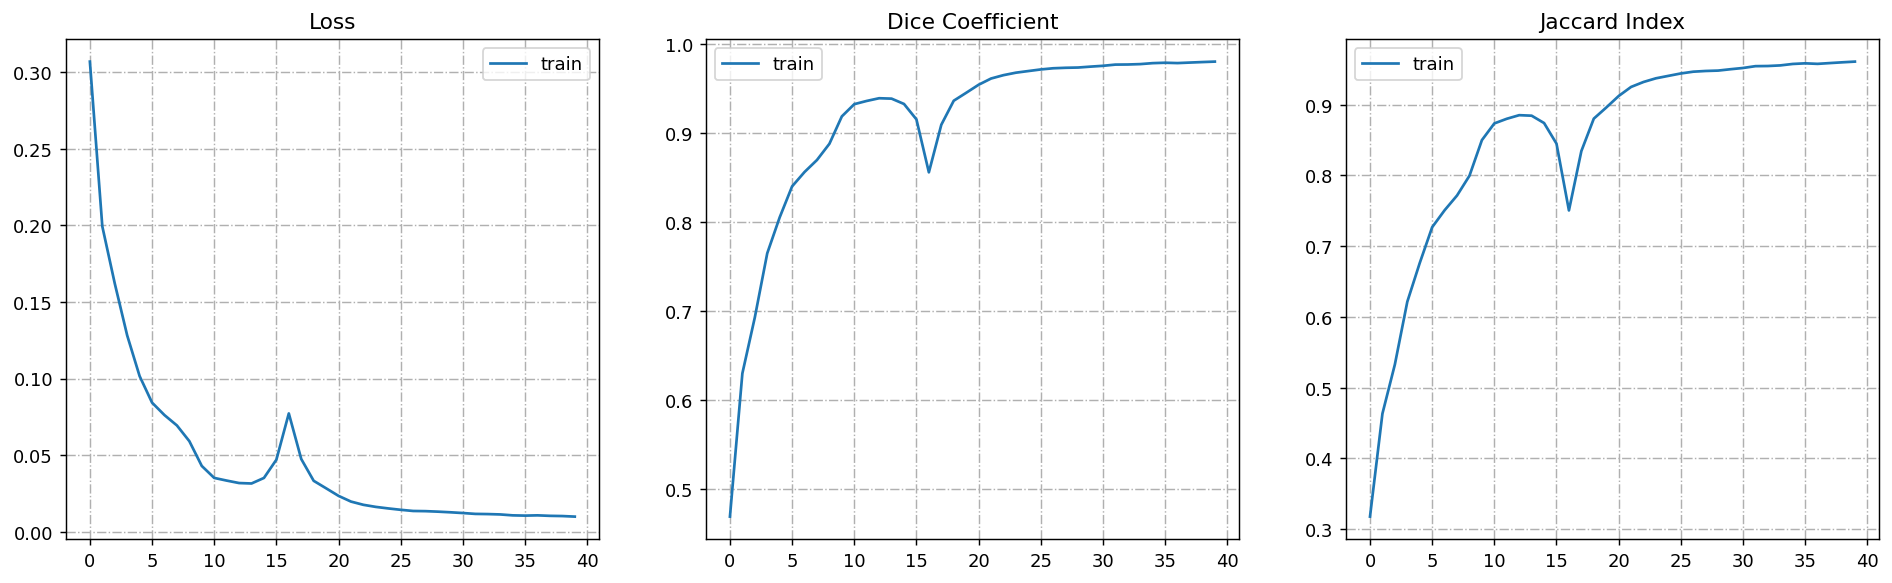

In [20]:
fig, axs = plt.subplots(1, 3, figsize=(18, 5), dpi=130)

axs[0].grid(linestyle="dashdot")
axs[0].set_title("Loss")
axs[0].plot(hist.history['loss'])
axs[0].legend(["train"])

axs[1].grid(linestyle="dashdot")
axs[1].set_title("Dice Coefficient")
axs[1].plot(hist.history['dice_coef'])
axs[1].legend(["train"])

axs[2].grid(linestyle="dashdot")
axs[2].set_title("Jaccard Index")
axs[2].plot(hist.history['jaccard'])
axs[2].legend(["train"])


In [21]:

test_eval = model.evaluate(test_dataset)


25/25 ━━━━━━━━━━━━━━━━━━━━ 7s 79ms/step - dice_coef: 0.8431 - dice_coef_loss: 0.1569 - jaccard: 0.7339 - loss: 0.2377


In [22]:
def evaluate_test_dataset_with_threshold(model, test_dataset, threshold=0.3):
    all_preds = []
    all_masks = []

    for batch in test_dataset:
        images, masks = batch
        preds = model.predict(images, verbose=0)
        preds = (preds > threshold).astype(np.float32)  # Cast to float32
        masks = masks.numpy().astype(np.float32)        # Cast to float32

        all_preds.append(preds)
        all_masks.append(masks)

    # Concatenate all batches
    all_preds = np.concatenate(all_preds, axis=0)
    all_masks = np.concatenate(all_masks, axis=0)

    # Flatten for metric calculation
    y_true_f = K.flatten(all_masks)
    y_pred_f = K.flatten(all_preds)

    intersection = K.sum(y_true_f * y_pred_f)
    dice = (2. * intersection + 1) / (K.sum(y_true_f) + K.sum(y_pred_f) + 1)
    jaccard = intersection / (K.sum(y_true_f) + K.sum(y_pred_f) - intersection + 1e-6)

    dice = dice.numpy()
    jaccard = jaccard.numpy()

    print(f"Thresholded Dice Coefficient: {dice:.4f}")
    print(f"Thresholded Jaccard Index: {jaccard:.4f}")

    return dice, jaccard
evaluate_test_dataset_with_threshold(model, test_dataset, threshold=0.3)


Thresholded Dice Coefficient: 0.8534
Thresholded Jaccard Index: 0.7443


(np.float32(0.8534033), np.float32(0.7442924))

In [23]:
test_take1 = test_dataset.take(-1)
test_take1_ = list(test_take1)
pred = model.predict(test_take1)

y_test_take = []
for x in range(len(test_take1_)):
    y_test_take.extend(test_take1_[x][1].numpy())

pred_ = np.squeeze(pred)

threshold_1  = 0.3 #threshold for prediction
bitmap_pred_1 = (pred_ > threshold_1).astype(np.uint8)

threshold_2  = 0.99 #threshold for prediction
bitmap_pred_2 = (pred_ > threshold_2).astype(np.uint8)


25/25 ━━━━━━━━━━━━━━━━━━━━ 5s 79ms/step


In [25]:
def evaluate_model_tf(model, test_dataset):
    import numpy as np
    from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

    y_true = []
    y_pred = []

    for images, labels in test_dataset:
        predictions = model.predict(images)
        y_true.extend(labels.numpy().flatten())
        y_pred.extend(predictions.flatten())

    # Convert to numpy arrays
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)

    # Convert probabilities to binary labels
    y_pred_labels = (y_pred > 0.5).astype(int)

    # Now use the classification metrics
    results = {
        "accuracy": accuracy_score(y_true, y_pred_labels),
        "precision": precision_score(y_true, y_pred_labels),
        "recall": recall_score(y_true, y_pred_labels),
        "f1_score": f1_score(y_true, y_pred_labels),
    }

    return results


In [26]:
# A function that calculating dice and jaccard metrics for prediction
def calc_dice_jaccard_for_prediction(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    y_true_f = tf.cast(y_true_f, tf.uint16)
    y_pred_f = tf.cast(y_pred_f, tf.uint16)

    intersection = K.sum(y_true_f * y_pred_f)
    dice = (2 * intersection+1) / (K.sum(y_true_f) + K.sum(y_pred_f) + 1)
    jaccard = intersection  / (K.sum(y_true_f) + K.sum(y_pred_f) - intersection)

    return dice.numpy(),jaccard.numpy()


# A function that creating 3 random images in the test set and prediction it
def random_test_sample_with_prediction():
    idxs = np.random.permutation(len(y_test_take))[:3]
    batch_idx = idxs // BATCH_SIZE
    image_idx = idxs-batch_idx * BATCH_SIZE
    idx = idxs


    fig, axs = plt.subplots(3,4, figsize = (10, 10 ) ,dpi = 150)

    for i in range(3):
        image = test_take1_[batch_idx[i]][0][image_idx[i]]
        mask = test_take1_[batch_idx[i]][1][image_idx[i]]
        pred_mask_1 = bitmap_pred_1[idx[i]]
        pred_mask_2 = bitmap_pred_2[idx[i]]

        dice1 = calc_dice_jaccard_for_prediction(mask, pred_mask_1)[0]
        jac1 = calc_dice_jaccard_for_prediction(mask, pred_mask_1)[1]

        dice2= calc_dice_jaccard_for_prediction(mask, pred_mask_2)[0]
        jac2= calc_dice_jaccard_for_prediction(mask, pred_mask_2)[1]


        axs[i][0].imshow(image , cmap = 'gray')
        axs[i][0].axis('off')
        axs[i][0].set_title('original image (no: ' + str(idxs[i]) + ")", fontsize = 6)

        axs[i][1].imshow(mask, cmap = 'gray')
        axs[i][1].axis('off')
        axs[i][1].set_title('original mask', fontsize = 6)

        axs[i][2].imshow(pred_mask_1 , cmap = 'gray')
        axs[i][2].axis('off')
        axs[i][2].set_title('pred mask (0.3 threshold)'
                            + '\n Dice Coef: {0:0.3f}'.format(dice1)
                            + '\n Jaccard Coef: {0:0.3f}'.format(jac1), color = 'red', fontsize = 6)

        axs[i][3].imshow(pred_mask_2 , cmap = 'gray')
        axs[i][3].axis('off')
        axs[i][3].set_title('pred mask (0.99 threshold)' + '\n Dice Coef: {0:0.3f}'.format(dice2) + '\n Jaccard Coef: {0:0.3f}'.format(jac2), color = 'red', fontsize = 6)

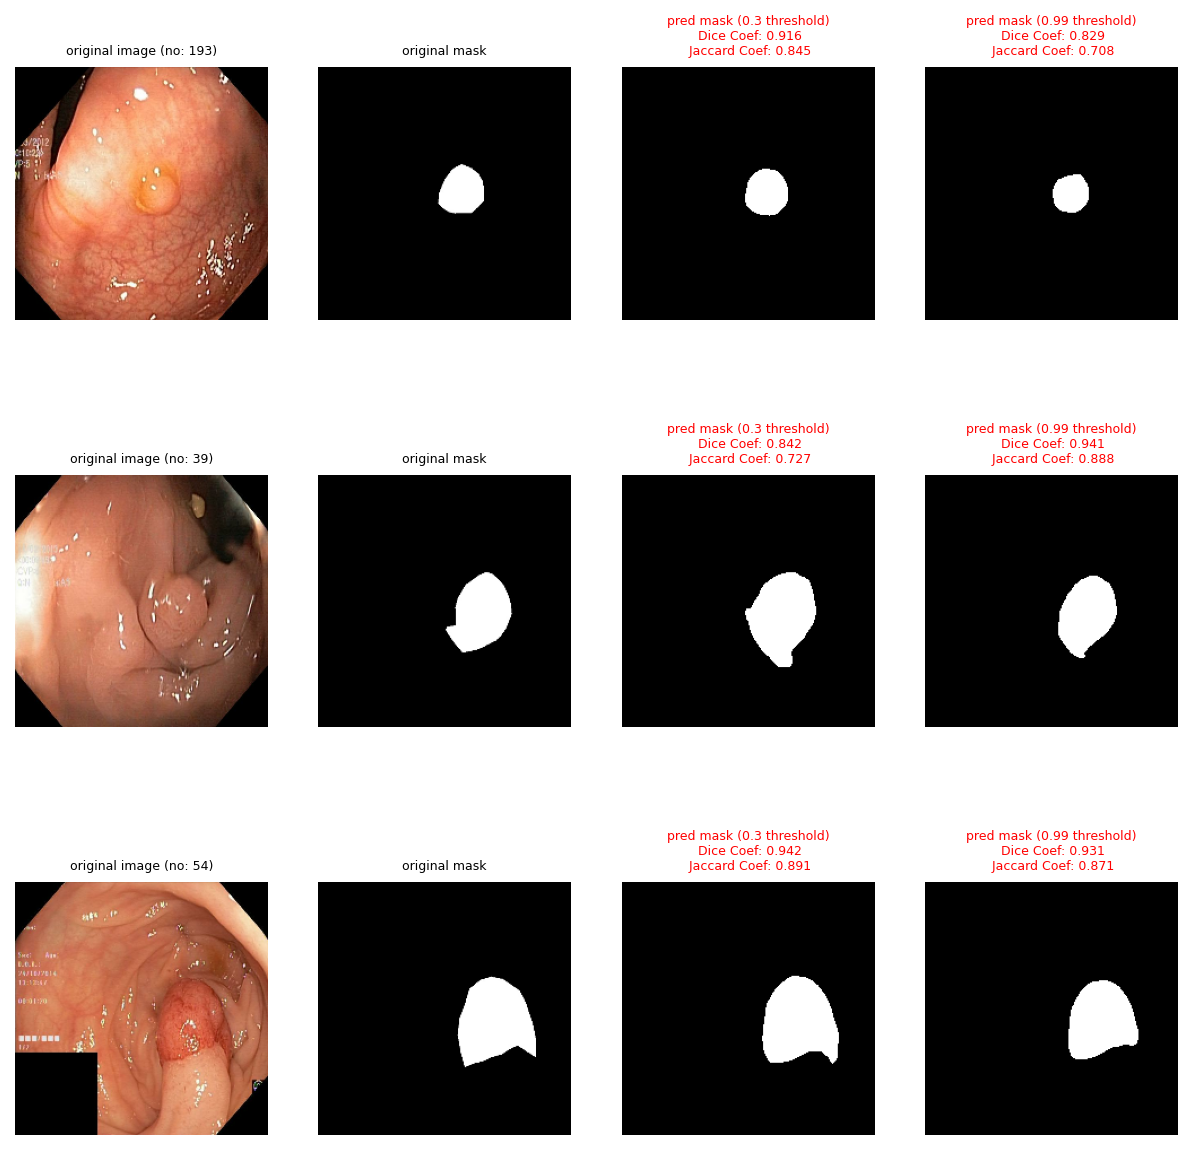

In [27]:
random_test_sample_with_prediction()